# importing dependencies

In [ ]:
import cv2
import os
import shutil
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Add, UpSampling2D, Input, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# downloading and decompressing the dataset

In [ ]:
!kaggle datasets download -d joe1995/div2k-dataset -p /content

Dataset URL: https://www.kaggle.com/datasets/joe1995/div2k-dataset
License(s): unknown
100% 3.70G/3.71G [00:32<00:00, 86.2MB/s]
100% 3.71G/3.71G [00:32<00:00, 124MB/s] 


In [ ]:
!unzip /content/div2k-dataset.zip -d /content/div2k-dataset

Archive:  /content/div2k-dataset.zip
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0001.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0002.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0003.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0004.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0005.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0006.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0007.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0008.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0009.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0010.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0011.png  
  inflating: /content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0012.png  
  inflating: /content/div2k-dataset/DIV

# setting up the directories

In [ ]:
train_data_dir = '/content/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR'
validation_data_dir = '/content/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR'
resized_train_dir = '/content/div2k-dataset/resized_train'
resized_valid_dir = '/content/div2k-dataset/resized_valid'
low_res_train_dir= '/content/div2k-dataset/low_res_train'
low_res_valid_dir= '/content/div2k-dataset/low_res_valid'
augmented_data_high = '/content/div2k-dataset/augmented_train_high/all'
augmented_data_low = '/content/div2k-dataset/augmented_train_low/all'

In [ ]:
!mkdir -p /content/div2k-dataset/augmented_train_high/all
!mkdir -p /content/div2k-dataset/augmented_train_low/all
!mkdir -p /content/training_checkpoints

# transforming the images

In [ ]:
import cv2
import os

target_size = (256, 256)
def resize_images(dir_path, output_dir):
    try:
        os.makedirs(output_dir, exist_ok=True)

        for filename in os.listdir(dir_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(dir_path, filename)
                img = cv2.imread(img_path)
                resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                output_path = os.path.join(output_dir, 'resized_' + filename)
                cv2.imwrite(output_path, resized_img)
    except Exception as e:
        print(f"Error processing images in {dir_path}: {e}")


resize_images(train_data_dir, resized_train_dir)
resize_images(validation_data_dir, resized_valid_dir)

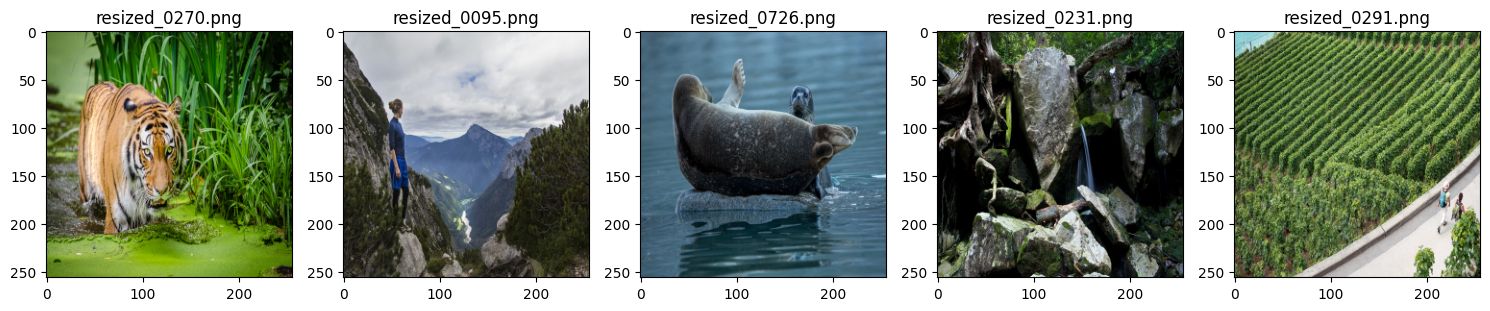

In [ ]:
import matplotlib.pyplot as plt

num_samples = 5

fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, filename in enumerate(os.listdir(resized_train_dir)[:num_samples]):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(resized_train_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(filename)

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

def create_low_resolution_dataset(input_dir, output_dir, scale_factor):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(input_dir, filename)
            img = cv2.imread(img_path)
            height, width = img.shape[:2]
            new_height, new_width = height // scale_factor, width // scale_factor
            low_res_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
            output_path = os.path.join(output_dir,filename)
            cv2.imwrite(output_path, low_res_img)


scale_factor = 2
create_low_resolution_dataset(resized_train_dir, low_res_train_dir, scale_factor)
create_low_resolution_dataset(resized_valid_dir, low_res_valid_dir, scale_factor)

#Augmentation

In [ ]:
import numpy as np



def random_crop(image, top, left, patch_size=(128,128), target_size= (256,256)):
    top,left= int(top), int(left)
    cropped_image = image[top:top + patch_size[0], left:left + patch_size[1]]
    resized= cv2.resize(cropped_image, target_size)
    return resized

def random_rotation(image, angle,  target_size= (256,256)):
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    resized= cv2.resize(rotated_image, target_size)
    return resized

def random_flip(image, flip_code,  target_size= (256,256)):
    flipped_image = cv2.flip(image, flip_code)
    resized= cv2.resize(flipped_image, target_size)
    return resized

def random_scaling(image, scale_factor,  target_size= (256,256)):
    scaled_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
    resized= cv2.resize(scaled_image, target_size)
    return resized



In [ ]:
import random

def augment_image(image, top, left, angle, flip_code, scale_factor, patch_size=(128,128), target_size= (256,256)):
    images= {}
    images["cropped_"]= random_crop(image, top, left, patch_size, target_size)
    images["rotated_"]=random_rotation(image, angle, target_size)
    images["flipped_"]=random_flip(image, flip_code, target_size)
    images["scaled_"]= random_scaling(image, scale_factor, target_size)

    return images

In [ ]:
max_angle= 360
max_scale_factor= 1.2
min_scale_factor= 0.8
patch_size=(128, 128)

def generate_augmentation_params(image_shape= (256,256,3), patch_size=(128, 128)):
    top = np.random.randint(0, image_shape[0] - patch_size[0])
    left = np.random.randint(0, image_shape[1] - patch_size[1])
    angle = np.random.uniform(-max_angle, max_angle)
    flip_code = np.random.randint(-1, 2)
    scale_factor = np.random.uniform(min_scale_factor, max_scale_factor)
    return top, left, angle, flip_code, scale_factor

In [ ]:
def augment_images_pair(high_res_dir, low_res_dir, high_res_output_dir, low_res_output_dir):
    if not os.path.exists(high_res_output_dir):
        os.makedirs(high_res_output_dir)
    if not os.path.exists(low_res_output_dir):
        os.makedirs(low_res_output_dir)

    for filename in os.listdir(high_res_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            high_res_img_path = os.path.join(high_res_dir, filename)
            low_res_img_path = os.path.join(low_res_dir, filename)

            high_res_image = cv2.imread(high_res_img_path)
            low_res_image = cv2.imread(low_res_img_path)

            top, left, angle, flip_code, scale_factor = generate_augmentation_params(high_res_image.shape)

            high_res_augmented = augment_image(high_res_image, top, left, angle, flip_code, scale_factor, patch_size=(128,128), target_size= (256,256))
            low_res_augmented = augment_image(low_res_image, top//2, left//2, angle, flip_code, scale_factor,patch_size=(64,64), target_size= (128,128))


            for key in high_res_augmented.keys():
                high_res_output_path = os.path.join(high_res_output_dir, f"{os.path.splitext(filename)[0]}_{key}{os.path.splitext(filename)[1]}")
                low_res_output_path = os.path.join(low_res_output_dir, f"{os.path.splitext(filename)[0]}_{key}{os.path.splitext(filename)[1]}")

                if high_res_augmented[key] is None or high_res_augmented[key].size == 0:
                    print(f"High-res augmentation {key} failed for image: {high_res_img_path}")
                    continue

                if low_res_augmented[key] is None or low_res_augmented[key].size == 0:
                    print(f"Low-res augmentation {key} failed for image: {low_res_img_path}")
                    continue

                cv2.imwrite(high_res_output_path, high_res_augmented[key])
                cv2.imwrite(low_res_output_path, low_res_augmented[key])


In [ ]:
augment_images_pair(high_res_dir=resized_train_dir, low_res_dir=low_res_train_dir, high_res_output_dir=augmented_data_high, low_res_output_dir=augmented_data_low)

# preparing the dataset

In [ ]:
import tensorflow as tf
import os

lr_image_size = (128, 128)
hr_image_size = (256, 256)
batch_size = 16


def load_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = (image / 127.5) - 1.0
    return image

def load_lr_hr_pair(lr_image_path, hr_image_path):
    lr_image = load_image(lr_image_path, lr_image_size)
    hr_image = load_image(hr_image_path, hr_image_size)
    return lr_image, hr_image

def create_dataset(lr_dir, hr_dir, batch_size):
    lr_image_paths = sorted([os.path.join(lr_dir, img) for img in os.listdir(lr_dir) if img.endswith(('.jpg', '.jpeg', '.png'))])
    hr_image_paths = sorted([os.path.join(hr_dir, img) for img in os.listdir(hr_dir) if img.endswith(('.jpg', '.jpeg', '.png'))])

    dataset = tf.data.Dataset.from_tensor_slices((lr_image_paths, hr_image_paths))
    dataset = dataset.map(lambda lr, hr: load_lr_hr_pair(lr, hr), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

train_lr_dir = '/content/div2k-dataset/augmented_train_low/all'
train_hr_dir = '/content/div2k-dataset/augmented_train_high/all'


train_dataset = create_dataset(train_lr_dir, train_hr_dir, batch_size)

for lr_batch, hr_batch in train_dataset.take(1):
    print(f'Train LR Batch shape: {lr_batch.shape}')
    print(f'Train HR Batch shape: {hr_batch.shape}')

Train LR Batch shape: (16, 128, 128, 3)
Train HR Batch shape: (16, 256, 256, 3)


# building the model

In [ ]:
def build_generator():
    input = Input(shape=(128, 128, 3))
    x = Conv2D(64, (9, 9), padding='same')(input)
    x = LeakyReLU(alpha=0.2)(x)

    res = x
    for _ in range(16):
        res = residual_block(res)

    res = Conv2D(64, (3, 3), padding='same')(res)
    res = BatchNormalization()(res)
    x = Add()([x, res])

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(3, (9, 9), padding='same', activation='tanh')(x)

    return Model(inputs=input, outputs=x)

def build_discriminator():
    input = Input(shape=(256, 256, 3))
    x = Conv2D(64, (3, 3), strides=1, padding='same')(input)
    x = LeakyReLU(alpha=0.2)(x)

    for filters in [64, 128, 128, 256, 256, 512, 512]:
        x = Conv2D(filters, (3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='tanh')(x)

    return Model(inputs=input, outputs=x)

def build_combined_model(generator, discriminator):
    discriminator.trainable = True
    hr_input = Input(shape=(128, 128, 3))
    generated_hr = generator(hr_input)
    valid = discriminator(generated_hr)
    return Model(inputs=hr_input, outputs=[generated_hr, valid])

def residual_block(x):
    filters = 64
    res = Conv2D(filters, (3, 3), padding='same')(x)
    res = BatchNormalization()(res)
    res = LeakyReLU(alpha=0.2)(res)
    res = Conv2D(filters, (3, 3), padding='same')(res)
    res = BatchNormalization()(res)
    return Add()([x, res])

In [ ]:
# Build models
generator = build_generator()
discriminator = build_discriminator()
combined_model = build_combined_model(generator, discriminator)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Loss functions

In [ ]:
# Function to define content loss
def content_loss(y_true, y_pred, vgg_model):
    return tf.keras.losses.MeanSquaredError()(vgg_model(y_true), vgg_model(y_pred))

# Function to define pixel loss
def pixel_loss(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)

# Function to define adversarial loss
def adversarial_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

# Function to define discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# training the model

In [ ]:
@tf.function
def train_step(lr_images, hr_images, generator, discriminator, vgg_model, generator_optimizer, discriminator_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        sr_images = generator(lr_images, training=True)

        gen_content_loss = content_loss(hr_images, sr_images, vgg_model)
        gen_pixel_loss = pixel_loss(hr_images, sr_images)
        gen_loss = gen_content_loss + 0.01 * gen_pixel_loss

        fake_output = discriminator(sr_images, training=True)
        disc_fake_loss = adversarial_loss(fake_output)
        real_output = discriminator(hr_images, training=True)
        disc_real_loss = discriminator_loss(real_output, fake_output)
        disc_loss = disc_real_loss + disc_fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(train_dataset, epochs, generator, discriminator, vgg_model, checkpoint_prefix):
    batch_size = 16
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1}/{epochs}")
        for lr_images, hr_images in tqdm(train_dataset):
            gen_loss, disc_loss = train_step(lr_images, hr_images, generator, discriminator, vgg_model, generator_optimizer, discriminator_optimizer)

        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')

        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# VGG model setup for content loss
vgg = tf.keras.applications.VGG19(include_top=False, input_shape=(256, 256, 3))
vgg.trainable = False
vgg_model = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)

train(train_dataset, epochs=100, generator=generator, discriminator=discriminator, vgg_model=vgg_model, checkpoint_prefix=checkpoint_prefix)

80134624/80134624 [==============================] - 0s 0us/step
Starting epoch 1/100


100%|██████████| 200/200 [03:07<00:00,  1.07it/s]


Epoch 1, Generator Loss: 0.02836555428802967, Discriminator Loss: 1.913082480430603
Starting epoch 2/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 2, Generator Loss: 0.021043121814727783, Discriminator Loss: 1.834215760231018
Starting epoch 3/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 3, Generator Loss: 0.01802613027393818, Discriminator Loss: 1.7746391296386719
Starting epoch 4/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 4, Generator Loss: 0.016466327011585236, Discriminator Loss: 1.7549943923950195
Starting epoch 5/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 5, Generator Loss: 0.015495994128286839, Discriminator Loss: 1.7560062408447266
Starting epoch 6/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 6, Generator Loss: 0.014692315831780434, Discriminator Loss: 1.7451531887054443
Starting epoch 7/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 7, Generator Loss: 0.014053430408239365, Discriminator Loss: 1.7456755638122559
Starting epoch 8/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 8, Generator Loss: 0.013567650690674782, Discriminator Loss: 1.735368013381958
Starting epoch 9/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 9, Generator Loss: 0.013171537779271603, Discriminator Loss: 1.7084031105041504
Starting epoch 10/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 10, Generator Loss: 0.012779234908521175, Discriminator Loss: 1.7085970640182495
Starting epoch 11/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 11, Generator Loss: 0.012470826506614685, Discriminator Loss: 1.70480477809906
Starting epoch 12/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 12, Generator Loss: 0.012196406722068787, Discriminator Loss: 1.7019482851028442
Starting epoch 13/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 13, Generator Loss: 0.011994914151728153, Discriminator Loss: 1.7047635316848755
Starting epoch 14/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 14, Generator Loss: 0.011728974990546703, Discriminator Loss: 1.7017735242843628
Starting epoch 15/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 15, Generator Loss: 0.011505383998155594, Discriminator Loss: 1.702242136001587
Starting epoch 16/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 16, Generator Loss: 0.01127028837800026, Discriminator Loss: 1.7012226581573486
Starting epoch 17/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 17, Generator Loss: 0.011049244552850723, Discriminator Loss: 1.7014946937561035
Starting epoch 18/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 18, Generator Loss: 0.010848681442439556, Discriminator Loss: 1.7028403282165527
Starting epoch 19/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 19, Generator Loss: 0.010678736492991447, Discriminator Loss: 1.7016515731811523
Starting epoch 20/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 20, Generator Loss: 0.010522861033678055, Discriminator Loss: 1.7015671730041504
Starting epoch 21/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 21, Generator Loss: 0.010388250462710857, Discriminator Loss: 1.7013015747070312
Starting epoch 22/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 22, Generator Loss: 0.010191407054662704, Discriminator Loss: 1.701012372970581
Starting epoch 23/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 23, Generator Loss: 0.010051349177956581, Discriminator Loss: 1.700701117515564
Starting epoch 24/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 24, Generator Loss: 0.00993396621197462, Discriminator Loss: 1.7011752128601074
Starting epoch 25/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 25, Generator Loss: 0.009811559692025185, Discriminator Loss: 1.7008295059204102
Starting epoch 26/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 26, Generator Loss: 0.009732898324728012, Discriminator Loss: 1.702260971069336
Starting epoch 27/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 27, Generator Loss: 0.009612317197024822, Discriminator Loss: 1.7007369995117188
Starting epoch 28/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 28, Generator Loss: 0.009492612443864346, Discriminator Loss: 1.7008733749389648
Starting epoch 29/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 29, Generator Loss: 0.00940237008035183, Discriminator Loss: 1.700814962387085
Starting epoch 30/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 30, Generator Loss: 0.009331420063972473, Discriminator Loss: 1.7015269994735718
Starting epoch 31/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 31, Generator Loss: 0.009213894605636597, Discriminator Loss: 1.7008861303329468
Starting epoch 32/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 32, Generator Loss: 0.009127733297646046, Discriminator Loss: 1.700751543045044
Starting epoch 33/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 33, Generator Loss: 0.009038858115673065, Discriminator Loss: 1.7947893142700195
Starting epoch 34/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 34, Generator Loss: 0.008943243883550167, Discriminator Loss: 1.7049832344055176
Starting epoch 35/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 35, Generator Loss: 0.008831913582980633, Discriminator Loss: 1.7007415294647217
Starting epoch 36/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 36, Generator Loss: 0.00874254573136568, Discriminator Loss: 1.7003253698349
Starting epoch 37/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 37, Generator Loss: 0.008753801696002483, Discriminator Loss: 1.7002339363098145
Starting epoch 38/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 38, Generator Loss: 0.008814144879579544, Discriminator Loss: 1.70021390914917
Starting epoch 39/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 39, Generator Loss: 0.00876636616885662, Discriminator Loss: 1.7002010345458984
Starting epoch 40/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 40, Generator Loss: 0.008727972395718098, Discriminator Loss: 1.7000294923782349
Starting epoch 41/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 41, Generator Loss: 0.008676772005856037, Discriminator Loss: 1.7003624439239502
Starting epoch 42/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 42, Generator Loss: 0.008444603532552719, Discriminator Loss: 1.6999841928482056
Starting epoch 43/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 43, Generator Loss: 0.008334171026945114, Discriminator Loss: 1.702368974685669
Starting epoch 44/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 44, Generator Loss: 0.008350776508450508, Discriminator Loss: 1.7012033462524414
Starting epoch 45/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 45, Generator Loss: 0.008242657408118248, Discriminator Loss: 1.7008352279663086
Starting epoch 46/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 46, Generator Loss: 0.008230810984969139, Discriminator Loss: 1.7006869316101074
Starting epoch 47/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 47, Generator Loss: 0.008205023594200611, Discriminator Loss: 1.699953556060791
Starting epoch 48/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 48, Generator Loss: 0.008165139704942703, Discriminator Loss: 1.7007794380187988
Starting epoch 49/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 49, Generator Loss: 0.008100539445877075, Discriminator Loss: 1.7001711130142212
Starting epoch 50/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 50, Generator Loss: 0.008006626740098, Discriminator Loss: 1.699981689453125
Starting epoch 51/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 51, Generator Loss: 0.008017434738576412, Discriminator Loss: 1.700584053993225
Starting epoch 52/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 52, Generator Loss: 0.007975058630108833, Discriminator Loss: 1.6999927759170532
Starting epoch 53/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 53, Generator Loss: 0.00792380329221487, Discriminator Loss: 1.7000075578689575
Starting epoch 54/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 54, Generator Loss: 0.007880095392465591, Discriminator Loss: 1.699925422668457
Starting epoch 55/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 55, Generator Loss: 0.007886560633778572, Discriminator Loss: 1.6999614238739014
Starting epoch 56/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 56, Generator Loss: 0.007864228449761868, Discriminator Loss: 1.7005279064178467
Starting epoch 57/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 57, Generator Loss: 0.007820122875273228, Discriminator Loss: 1.6998815536499023
Starting epoch 58/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 58, Generator Loss: 0.00777851976454258, Discriminator Loss: 1.6999878883361816
Starting epoch 59/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 59, Generator Loss: 0.007741679437458515, Discriminator Loss: 1.7004231214523315
Starting epoch 60/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 60, Generator Loss: 0.007750122342258692, Discriminator Loss: 1.7000073194503784
Starting epoch 61/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 61, Generator Loss: 0.007703688461333513, Discriminator Loss: 1.7002246379852295
Starting epoch 62/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 62, Generator Loss: 0.007640321739017963, Discriminator Loss: 1.7001409530639648
Starting epoch 63/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 63, Generator Loss: 0.007526159752160311, Discriminator Loss: 1.699903964996338
Starting epoch 64/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 64, Generator Loss: 0.007380965165793896, Discriminator Loss: 1.7006556987762451
Starting epoch 65/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 65, Generator Loss: 0.0073715271428227425, Discriminator Loss: 1.701390266418457
Starting epoch 66/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 66, Generator Loss: 0.007436682004481554, Discriminator Loss: 1.6998825073242188
Starting epoch 67/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 67, Generator Loss: 0.0074110790155828, Discriminator Loss: 1.701552391052246
Starting epoch 68/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 68, Generator Loss: 0.007442920934408903, Discriminator Loss: 1.6999831199645996
Starting epoch 69/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 69, Generator Loss: 0.0075240666046738625, Discriminator Loss: 1.699882984161377
Starting epoch 70/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 70, Generator Loss: 0.007447266019880772, Discriminator Loss: 1.6997836828231812
Starting epoch 71/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 71, Generator Loss: 0.007336883340030909, Discriminator Loss: 1.6997549533843994
Starting epoch 72/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 72, Generator Loss: 0.007215216290205717, Discriminator Loss: 1.6997992992401123
Starting epoch 73/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 73, Generator Loss: 0.007047480437904596, Discriminator Loss: 1.6997039318084717
Starting epoch 74/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 74, Generator Loss: 0.007004397921264172, Discriminator Loss: 1.6997203826904297
Starting epoch 75/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 75, Generator Loss: 0.006945849861949682, Discriminator Loss: 1.6997883319854736
Starting epoch 76/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 76, Generator Loss: 0.0068742274306714535, Discriminator Loss: 1.6997284889221191
Starting epoch 77/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 77, Generator Loss: 0.006824176292866468, Discriminator Loss: 1.6997216939926147
Starting epoch 78/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 78, Generator Loss: 0.006849403493106365, Discriminator Loss: 1.700257658958435
Starting epoch 79/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 79, Generator Loss: 0.006822908762842417, Discriminator Loss: 1.7118529081344604
Starting epoch 80/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 80, Generator Loss: 0.006841277237981558, Discriminator Loss: 1.7028125524520874
Starting epoch 81/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 81, Generator Loss: 0.006709391716867685, Discriminator Loss: 1.7011632919311523
Starting epoch 82/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 82, Generator Loss: 0.006699382793158293, Discriminator Loss: 1.7003841400146484
Starting epoch 83/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 83, Generator Loss: 0.006646992173045874, Discriminator Loss: 1.7002136707305908
Starting epoch 84/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 84, Generator Loss: 0.006697527598589659, Discriminator Loss: 1.7004120349884033
Starting epoch 85/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 85, Generator Loss: 0.006747918203473091, Discriminator Loss: 1.7000372409820557
Starting epoch 86/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 86, Generator Loss: 0.006722812540829182, Discriminator Loss: 1.6998341083526611
Starting epoch 87/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 87, Generator Loss: 0.006705832667648792, Discriminator Loss: 1.6997768878936768
Starting epoch 88/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 88, Generator Loss: 0.006719707977026701, Discriminator Loss: 1.699924111366272
Starting epoch 89/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 89, Generator Loss: 0.006668480113148689, Discriminator Loss: 1.6998969316482544
Starting epoch 90/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 90, Generator Loss: 0.006565703544765711, Discriminator Loss: 1.69989013671875
Starting epoch 91/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 91, Generator Loss: 0.0064164213836193085, Discriminator Loss: 1.6998448371887207
Starting epoch 92/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 92, Generator Loss: 0.006338395643979311, Discriminator Loss: 1.699942946434021
Starting epoch 93/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 93, Generator Loss: 0.0062989299185574055, Discriminator Loss: 1.6998286247253418
Starting epoch 94/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 94, Generator Loss: 0.006311929784715176, Discriminator Loss: 1.700194239616394
Starting epoch 95/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 95, Generator Loss: 0.006327011622488499, Discriminator Loss: 1.700136661529541
Starting epoch 96/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 96, Generator Loss: 0.006305655464529991, Discriminator Loss: 1.7003121376037598
Starting epoch 97/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 97, Generator Loss: 0.006278096232563257, Discriminator Loss: 1.6997814178466797
Starting epoch 98/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 98, Generator Loss: 0.0062827761285007, Discriminator Loss: 1.6999704837799072
Starting epoch 99/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 99, Generator Loss: 0.006198723800480366, Discriminator Loss: 1.699798583984375
Starting epoch 100/100


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Epoch 100, Generator Loss: 0.006187393330037594, Discriminator Loss: 1.6998203992843628


# Evaluation

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint("/content/training_checkpoints"))

In [ ]:
sr_image = generator.predict(tf.expand_dims("/content/div2k-dataset/low_res_valid/resized_0842.png", axis=0))

In [ ]:
generator.save("generator.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Original LR image min value: 0.0
Original LR image max value: 1.0
Normalized LR image min value: -1.0
Normalized LR image max value: 1.0


SR image min value before denormalization: -0.985726
SR image max value before denormalization: 0.9672153
Denormalized LR image min value: 0
Denormalized LR image max value: 255
Denormalized SR image min value: 1
Denormalized SR image max value: 250


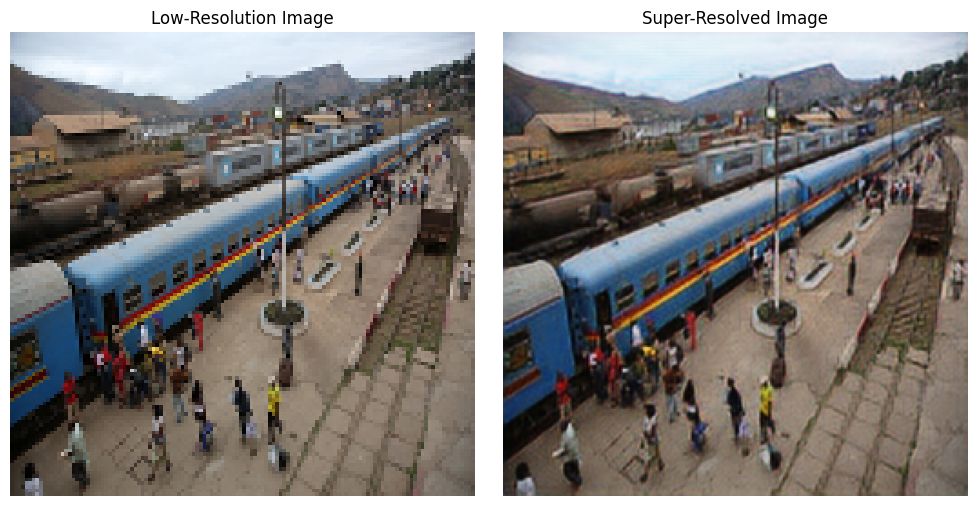

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def normalize_image(image):
    return (image * 2.0) - 1.0

def denormalize_image(image):
    return ((image + 1.0) / 2.0 * 255.0).clip(0, 255).astype(np.uint8)

lr_image_path = '/content/div2k-dataset/low_res_valid/resized_0850.png'
lr_image = tf.io.read_file(lr_image_path)
lr_image = tf.image.decode_image(lr_image, channels=3)
lr_image = tf.image.convert_image_dtype(lr_image, tf.float32)

lr_image_normalized = normalize_image(lr_image)



generator = tf.keras.models.load_model('/content/generator.h5')

sr_image = generator(tf.expand_dims(lr_image_normalized, axis=0), training=False)
sr_image = tf.squeeze(sr_image, axis=0).numpy()


lr_image_rgb = denormalize_image(lr_image_normalized.numpy())
sr_image_rgb = denormalize_image(sr_image)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Low-Resolution Image')
plt.imshow(lr_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Enhanced Image')
plt.imshow(sr_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()
